In [1]:
import os.path as op
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from ordering_methods import create_order_3_channels, create_order_single_channel

In [2]:
# prefix = "/work/scratch/malinoro/histogram_transfer/data"
prefix = "/Users/roman/Code/Histogram_transfer/data/"

# Reading or creating images

In [ ]:
img1 = cv.cvtColor(cv.imread(op.join(prefix, "MiddleBury", "cones.ppm")), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread(op.join(prefix, "MiddleBury", "teddy.ppm")), cv.COLOR_BGR2RGB)
img1 = cv.resize(img1, dsize=(360, 300))
img2 = cv.resize(img2, dsize=(360, 300))

## Fake image
X, Y = np.meshgrid(np.linspace(0, 255, img1.shape[1]), np.linspace(0, 255, img1.shape[0]))
R, G, B = np.sqrt((X**2+Y**2)/2), np.sqrt(((255-X)**2+Y**2)/2), np.sqrt(((255-X)**2+(255-Y)**2)/2)
R, G, B = R.astype(dtype=np.uint8), G.astype(dtype=np.uint8), B.astype(dtype=np.uint8) 
img0 = cv.merge([R, G, B])

# Choosing and image, smoothing it, HSV, and separating channels

In [ ]:
img = img1
img_ref = img0

# HSV
hsv_img = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv_ref = cv.cvtColor(img_ref, cv.COLOR_RGB2HSV)

# Smooth image
img_smooth = cv.GaussianBlur(img, (5, 5), 0)
hsv_smooth = cv.GaussianBlur(hsv_img, (5, 5), 0)

# Separating channels
rgb_planes = cv.split(img)
rgb_ref_planes = cv.split(img_ref)
rgb_smooth_planes = cv.split(img_smooth)

hsv_planes = cv.split(hsv_img)
hsv_ref_planes = cv.split(hsv_ref)
hsv_smooth_planes = cv.split(hsv_smooth)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
axes[0,0].imshow(img)
axes[0,1].imshow(img_smooth)

n_bins = 80
for k, c in zip(range(3), ["r", "g", "b"]):
    counts, bins = np.histogram(rgb_planes[k], bins=n_bins, density=True)
    axes[1,0].stairs(counts, bins, color=c)
    axes[1,1].stairs(np.cumsum(counts), bins, baseline=None, color=c)
    
plt.show()


In [ ]:
cumulated_hist = True

bins_3d = (20, 20, 20)
X, Y, Z = np.meshgrid(*[np.linspace(0, 255, b) for b in bins_3d])

# This compute the histogram in N dimensions
if cumulated_hist:
    counts, _ = np.histogramdd(np.array(img).reshape(-1, 3), bins=bins_3d)
    counts = counts.cumsum(axis=0).cumsum(axis=1).cumsum(axis=2) / np.sum(counts)
    iso_min, iso_max = 0, 1
else:
    counts, _ = np.histogramdd(np.array(img).reshape(-1, 3), bins=bins_3d, density=True)
    iso_min, iso_max = np.quantile(counts, 0.5), counts.max()

    
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    isomin=iso_min,
    isomax=iso_max,
    value=counts.flatten(),
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))

fig.update_layout(autosize=False, width=500, height=500, scene=dict(xaxis_title='Red', yaxis_title='Green', zaxis_title='Blue'))
fig.show()

### Verifying that the histogram is correctly computed

## Sorting the image for RGB

In [ ]:
order_ref = create_order_3_channels(img_ref)
order = create_order_3_channels(img, img_smooth, complete=True)

In [ ]:
img_transfered = img.copy()
img_transfered[order] = img_ref[order_ref]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axes[0].imshow(img)
axes[1].imshow(img_ref)
axes[2].imshow(img_transfered)

## Sorting the image for RGB taken separetly

In [ ]:
r_order_ref = create_order_single_channel(rgb_ref_planes[0])
r_order = create_order_single_channel(rgb_planes[0], rgb_smooth_planes[0], complete=True)
r_transfered = rgb_planes[0].copy()
r_transfered[r_order] = rgb_ref_planes[0][r_order_ref]

g_order_ref = create_order_single_channel(rgb_ref_planes[1])
g_order = create_order_single_channel(rgb_planes[1], rgb_smooth_planes[1], complete=True)
g_transfered = rgb_planes[1].copy()
g_transfered[g_order] = rgb_ref_planes[1][g_order_ref]

b_order_ref = create_order_single_channel(rgb_ref_planes[2])
b_order = create_order_single_channel(rgb_planes[2], rgb_smooth_planes[2], complete=True)
b_transfered = rgb_planes[2].copy()
b_transfered[b_order] = rgb_ref_planes[2][b_order_ref]

img_channels_transfered = cv.merge([r_transfered, g_transfered, b_transfered])

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axes[0].imshow(img)
axes[1].imshow(img_ref)
axes[2].imshow(img_channels_transfered)

plt.show()

## Sorting the image for HSV

In [ ]:
order_ref = create_order_3_channels(hsv_ref)
order = create_order_3_channels(hsv_img, hsv_smooth, complete=True)

In [ ]:
hsv_transfered = hsv_img.copy()
hsv_transfered[order] = hsv_ref[order_ref]
hsv_transfered = cv.cvtColor(hsv_transfered, cv.COLOR_HSV2RGB)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axes[0].imshow(img)
axes[1].imshow(img_ref)
axes[2].imshow(hsv_transfered)

## Sorting the image for HSV taken separetly

In [ ]:
h_order_ref = create_order_single_channel(hsv_ref_planes[0])
h_order = create_order_single_channel(hsv_planes[0], hsv_smooth_planes[0], complete=True)
h_transfered = hsv_planes[0].copy()
h_transfered[h_order] = hsv_ref_planes[0][h_order_ref]

s_order_ref = create_order_single_channel(hsv_ref_planes[1])
s_order = create_order_single_channel(hsv_planes[1], hsv_smooth_planes[1], complete=True)
s_transfered = hsv_planes[1].copy()
s_transfered[s_order] = hsv_ref_planes[1][s_order_ref]

v_order_ref = create_order_single_channel(hsv_ref_planes[2])
v_order = create_order_single_channel(hsv_planes[2], hsv_smooth_planes[2], complete=True)
v_transfered = hsv_planes[2].copy()
v_transfered[v_order] = hsv_ref_planes[2][v_order_ref]

hsv_channels_transfered = cv.cvtColor(cv.merge([h_transfered, s_transfered, v_transfered]), cv.COLOR_HSV2RGB)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axes[0].imshow(img)
axes[1].imshow(img_ref)
axes[2].imshow(hsv_channels_transfered)

plt.show()

# Plotting all methods at once

In [ ]:
hsv_channels_transfered 
hsv_transfered 
img_channels_transfered
img_transfered

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes[0,1].imshow(img_transfered)
axes[1,0].imshow(img_channels_transfered)
axes[1,2].imshow(hsv_transfered)
axes[2,1].imshow(hsv_channels_transfered)

axes[0,1].set_title("Transfer on RGB")
axes[1,0].set_title("Transfer on RGB independently")
axes[1,2].set_title("Transfer on HSV")
axes[2,1].set_title("Transfer on HSV independently")


axes[0,0].imshow(img_ref)
axes[0,2].imshow(img_ref)
axes[2,0].imshow(img_ref)
axes[2,2].imshow(img_ref)
axes[1,1].imshow(img)

axes[0,0].set_title("Reference image")
axes[0,2].set_title("Reference image")
axes[2,0].set_title("Reference image")
axes[2,2].set_title("Reference image")
axes[1,1].set_title("Original image")



plt.show()

# Independant channels

In [3]:
from statistical_analysis import cvt_ruderman, cvt_back_ruderman

In [4]:
image_BGR = cv.imread(op.join(prefix, "MiddleBury", "cones.ppm"))

## Fake image
X, Y = np.meshgrid(np.linspace(0, 255, image_BGR.shape[1]), np.linspace(0, 255, image_BGR.shape[0]))
R, G, B = np.sqrt((X**2+Y**2)/2), np.sqrt(((255-X)**2+Y**2)/2), np.sqrt(((255-X)**2+(255-Y)**2)/2)
R, G, B = R.astype(dtype=np.uint8), G.astype(dtype=np.uint8), B.astype(dtype=np.uint8) 
image_ref_BGR = cv.merge([B, G, R])

In [5]:
image_XYZ = cv.cvtColor(image_BGR, cv.COLOR_BGR2XYZ)
ruderman = cvt_ruderman(image_XYZ)
img_XYZ = cvt_back_ruderman(ruderman)

img_XYZ[np.nonzero(~(img_XYZ>0))] = 0  # removes nan
img_XYZ = np.round(img_XYZ).astype(dtype=image_XYZ.dtype)  # int8 creates some issue (values from -128 to 127)

img_BGR = cv.cvtColor(img_XYZ, cv.COLOR_XYZ2RGB)

/Users/roman/Code/Histogram_transfer/statistical_analysis.py:16: RuntimeWarning: divide by zero encountered in log10
  log_LMS = np.log10(img_LMS)
/Users/roman/Code/Histogram_transfer/statistical_analysis.py:20: RuntimeWarning: invalid value encountered in matmul
  ruderman = np.matmul(log_LMS, LMS2ruderman)
/Users/roman/Code/Histogram_transfer/statistical_analysis.py:32: RuntimeWarning: invalid value encountered in matmul
  log_LMS = np.matmul(ruderman, ruderman2LMS)


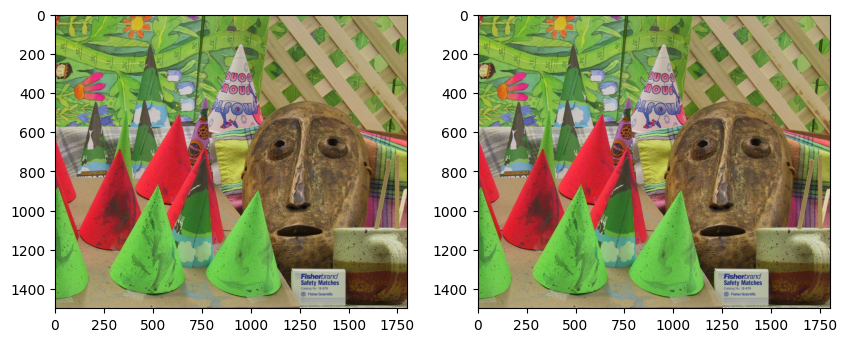

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axes[0].imshow(cv.cvtColor(image_BGR, cv.COLOR_BGR2RGB))
axes[1].imshow(img_BGR)